In [1]:
import torch
import librosa
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import sklearn.metrics as metrics

LABELS = {
    "piano": 0,
    "drums": 1,
    "bass": 2,
    "guitar": 3,
    "no_music": 4
}



Model

In [2]:
class InstrumentClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(InstrumentClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Adaptive pooling to 1x1

        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)  # 30% dropout
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten before FC layers

        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

Dataset

In [3]:
class BabySlakhDataset(Dataset):
    def __init__(self, stem_dict, segment_duration=2.0, sample_rate=22050, n_mels=128, energy_threshold=0.01, num_classes=5):
        """
        Args:
            stem_dict (dict): Dictionary mapping file paths to lists of labels.
            segment_duration (float): Duration (in seconds) of each segment.
            sample_rate (int): Audio sample rate.
            n_mels (int): Number of Mel spectrogram bins.
            energy_threshold (float): Threshold to determine if audio segment has music.
            num_classes (int): Total number of instrument classes.
        """
        self.sample_rate = sample_rate
        self.segment_samples = int(segment_duration * sample_rate)
        self.mel_transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
        self.segments = []
        self.num_classes = num_classes

        for path, labels in stem_dict.items():
            waveform, sr = librosa.load(path, sr=self.sample_rate)
            total_samples = len(waveform)

            for start in range(0, total_samples, self.segment_samples):
                end = start + self.segment_samples
                segment = waveform[start:end]
                if len(segment) < self.segment_samples:
                    continue  # Skip incomplete segment

                energy = np.mean(np.abs(segment))
                if energy < energy_threshold:
                    multi_hot = torch.zeros(num_classes)  # No music → all zeros
                    multi_hot[LABELS["no_music"]] = 1
                else:
                    multi_hot = torch.zeros(num_classes)
                    for label in labels:  # Set 1s for multiple labels
                        multi_hot[label] = 1

                self.segments.append((segment, multi_hot))

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        waveform_segment, multi_hot_label = self.segments[idx]
        mel_spec = self.mel_transform(torch.tensor(waveform_segment).unsqueeze(0))
        mel_spec = torch.log1p(mel_spec)  # Convert to log-scale for stability
        return mel_spec, multi_hot_label  # Multi-hot labels for multi-class classification

Confusion Matrix

In [4]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(all_labels, all_preds, class_names, label="Validation"):
    """
    Plots a heatmap for multi-label confusion matrices.

    all_labels: Ground truth labels (multi-hot encoded)
    all_preds: Predicted labels (multi-hot encoded)
    class_names: List of class names corresponding to indices
    label: String label for the dataset (Validation/Test)
    """
    conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)

    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))
    fig.suptitle(f"{label} Confusion Matrices", fontsize=16)

    for i, class_name in enumerate(class_names):
        cm = conf_matrices[i]  # Get the confusion matrix for class i

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=axes[i])
        axes[i].set_title(class_name)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2) 
    plt.show()

Prediction vs Accuracy

In [5]:
from sklearn.metrics import f1_score

def plot_f1_score(all_labels, all_preds, class_names):
    """
    Plot F1-Score for each class and overall.
    
    all_labels: Ground truth labels (multi-hot encoded)
    all_preds: Predicted labels (binary)
    class_names: List of class names corresponding to indices
    """
    f1_scores = []
    
    for i, class_name in enumerate(class_names):
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        f1_scores.append(f1)
    
    # Plot F1 Score
    plt.figure(figsize=(4, 3))
    plt.bar(class_names, f1_scores, color='lightgreen')
    plt.axhline(y=np.mean(f1_scores), color='r', linestyle='-', label = "Mean F1 score")
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score for Multi-label Classification')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

Precision

In [6]:
from sklearn.metrics import average_precision_score

def plot_average_precision(all_labels, all_preds, class_names):
    """
    Plot Average Precision (AP) for each class and mean Average Precision (mAP).
    
    all_labels: Ground truth labels (multi-hot encoded)
    all_preds: Predicted labels (probabilities or scores)
    class_names: List of class names corresponding to indices
    """
    ap_scores = []
    
    for i, class_name in enumerate(class_names):
        ap = average_precision_score(all_labels[:, i], all_preds[:, i])
        ap_scores.append(ap)
    
    # Plot Average Precision scores
    plt.figure(figsize=(4, 3))
    plt.bar(class_names, ap_scores, color='skyblue')
    plt.axhline(y=np.mean(ap_scores), color='r', linestyle='-', label = "Mean average precision")
    plt.xlabel('Class')
    plt.ylabel('Average Precision')
    plt.title('Average Precision for Multi-label Classification')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Evaluation

In [7]:
def evaluate(model, dataloader, label="Validation", epoch_num = 0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for mel_spec, labels in dataloader:
            mel_spec, labels = mel_spec.to(device), labels.to(device)

            outputs = model(mel_spec)
            predicted = torch.sigmoid(outputs) >= 0.5  # Convert to binary predictions

            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Compute multi-label accuracy
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    print(f"{label} Accuracy: {accuracy*100:.2f}%")

    class_names = list(LABELS.keys())
    if epoch_num % 5 == 0:
      # Plot the confusion matrix
      plot_confusion_matrix(all_labels, all_preds, class_names, label=label)
    if label == "Test":
      plot_f1_score(all_labels, all_preds, class_names)
      plot_average_precision(all_labels, all_preds, class_names)

    return accuracy, all_preds

Training

In [8]:
def train_with_val(model, train_loader, val_loader, epochs, lr=0.001, num_classes=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()  # Multi-label loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for mel_spec, labels in train_loader:
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)  # Now labels are multi-hot

            optimizer.zero_grad()
            outputs = model(mel_spec)  # Get raw logits

            loss = criterion(outputs, labels.float())  # Compute loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # **Fix accuracy calculation**
            predicted = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = (predicted >= 0.5).float()  # Thresholding

            correct = (predicted == labels).sum().item()  # Compare entire multi-hot labels
            total_correct += correct
            total_samples += labels.numel()  # Total elements (all classes for all samples)

        # Calculate accuracy
        train_acc = 100 * total_correct / total_samples
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        evaluate(model, val_loader, "Validation", epoch)

Define Data

In [9]:
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
track_name = "Track00001"
guitar_path = os.path.join(project_root, "data", "raw", track_name, "stems", "S00.wav")
drums_path = os.path.join(project_root, "data", "raw", track_name, "stems", "S01.wav")
piano_path = os.path.join(project_root, "data", "raw", track_name, "stems", "S02.wav")
bass_path = os.path.join(project_root, "data", "raw", track_name, "stems", "S03.wav")
combined_path = os.path.join(project_root, "data", "raw", track_name, "stems", "combined.wav")

stem_dict = {
    guitar_path: [LABELS["guitar"]],                  # Single label
    drums_path: [LABELS["drums"]],                   # Single label
    piano_path: [LABELS["piano"]],                   # Single label
    bass_path: [LABELS["bass"]],                    # Single label
    combined_path: [LABELS["piano"], LABELS["bass"]],  # Multi-label: Piano & Bass
}


K-Folds

c:\Users\Daphne\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


--- Fold 1 ---
Epoch 1/5 | Train Loss: 22.6096 | Train Accuracy: 79.35%
Validation Accuracy: 16.30%


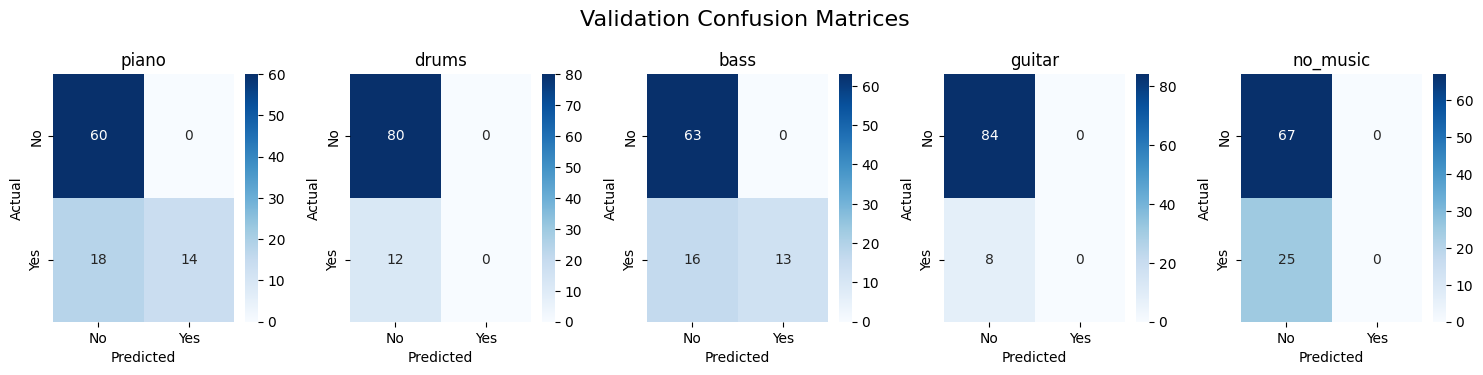

Epoch 2/5 | Train Loss: 14.7419 | Train Accuracy: 87.83%
Validation Accuracy: 66.30%
Epoch 3/5 | Train Loss: 10.4455 | Train Accuracy: 91.52%
Validation Accuracy: 76.09%
Epoch 4/5 | Train Loss: 7.2320 | Train Accuracy: 94.51%
Validation Accuracy: 82.61%
Epoch 5/5 | Train Loss: 6.9613 | Train Accuracy: 94.95%
Validation Accuracy: 85.87%

--- Final Test Evaluation ---
Test Accuracy: 84.35%


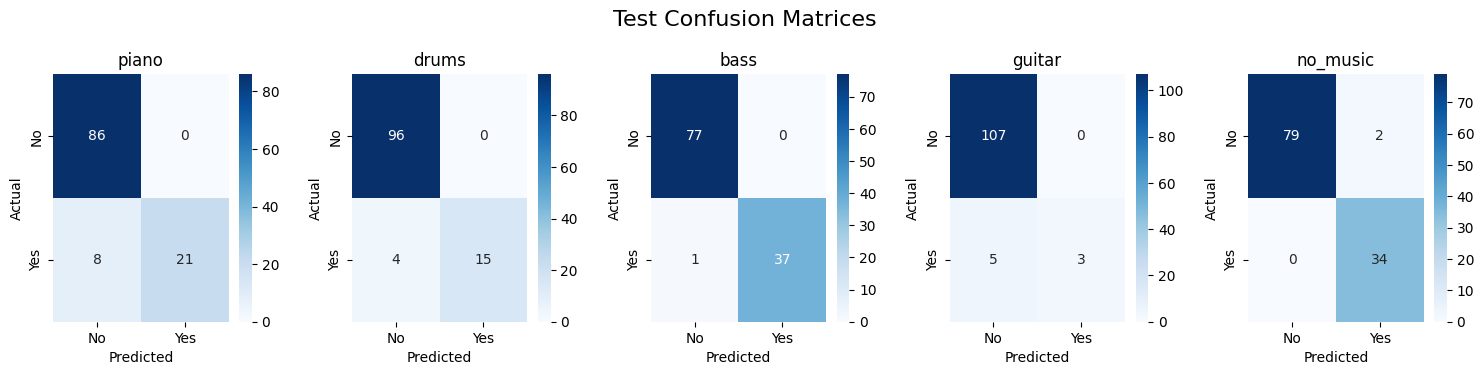

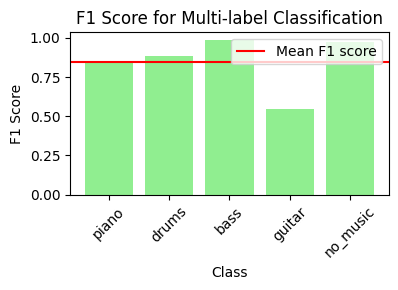

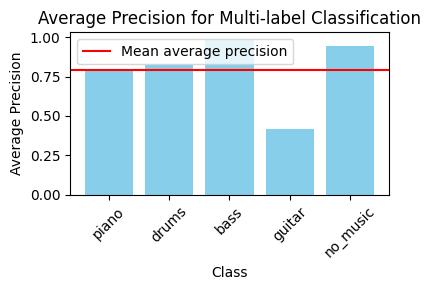


--- Fold End ---
--- Fold 2 ---
Epoch 1/5 | Train Loss: 22.1434 | Train Accuracy: 81.14%
Validation Accuracy: 17.39%


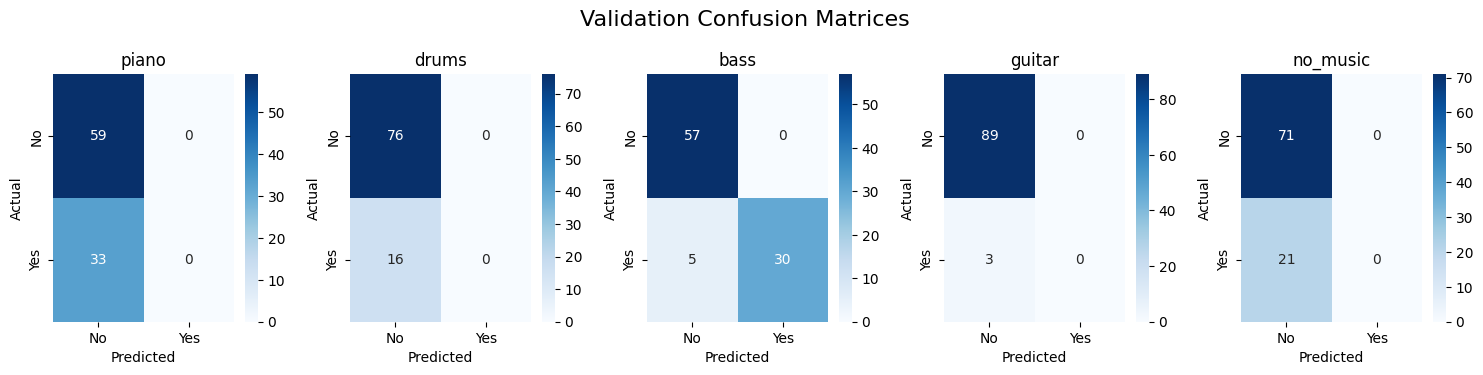

Epoch 2/5 | Train Loss: 14.3441 | Train Accuracy: 87.99%
Validation Accuracy: 55.43%
Epoch 3/5 | Train Loss: 10.1410 | Train Accuracy: 91.79%
Validation Accuracy: 69.57%
Epoch 4/5 | Train Loss: 7.7541 | Train Accuracy: 93.80%
Validation Accuracy: 86.96%
Epoch 5/5 | Train Loss: 6.4204 | Train Accuracy: 95.54%
Validation Accuracy: 86.96%

--- Final Test Evaluation ---
Test Accuracy: 90.43%


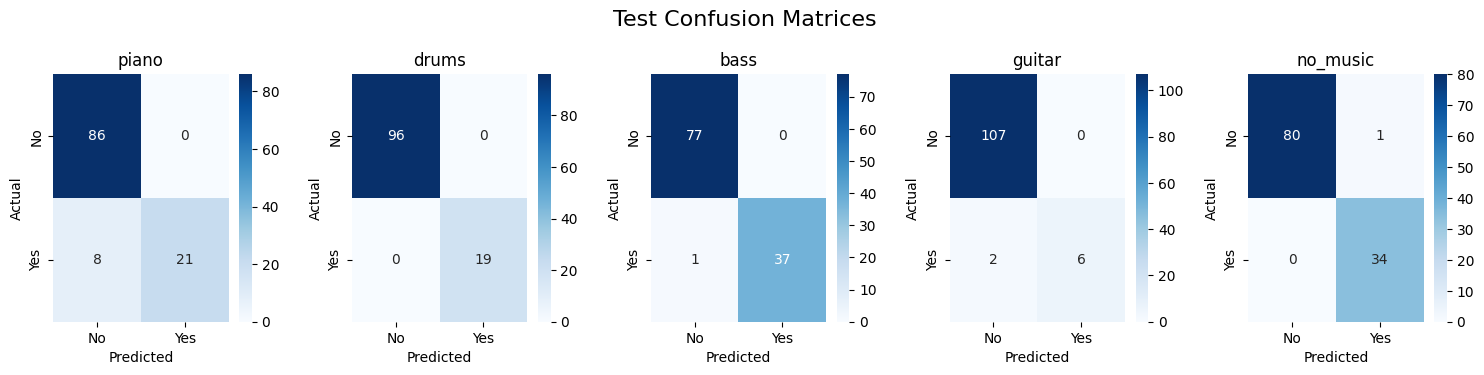

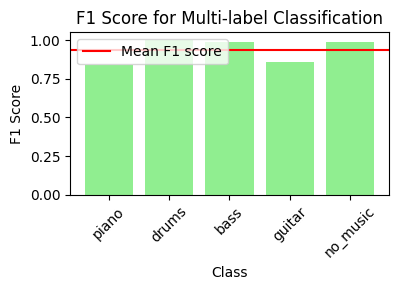

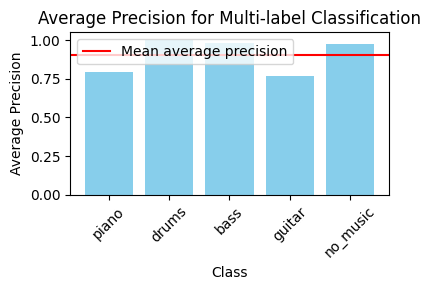


--- Fold End ---
--- Fold 3 ---
Epoch 1/5 | Train Loss: 24.3240 | Train Accuracy: 77.28%
Validation Accuracy: 25.00%


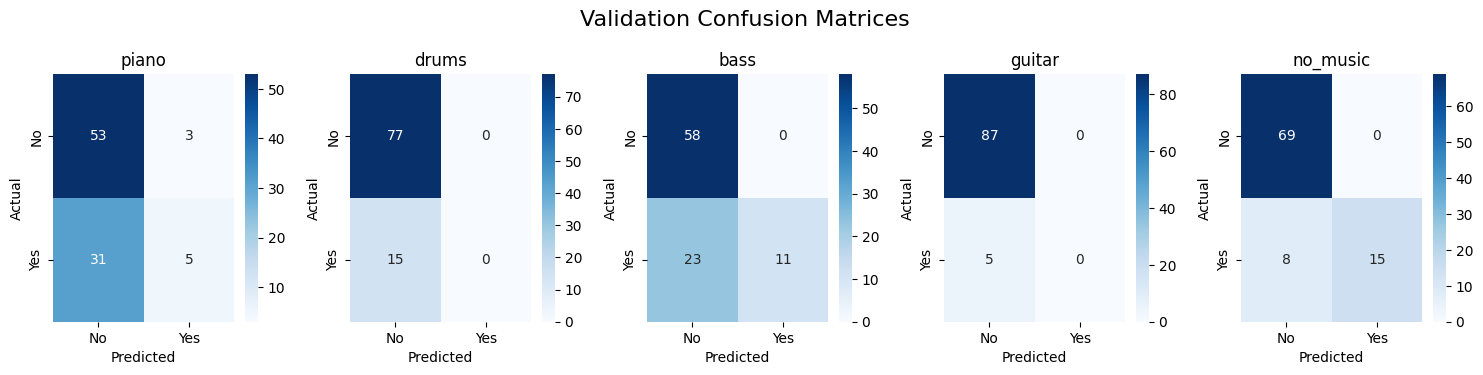

Epoch 2/5 | Train Loss: 14.8877 | Train Accuracy: 88.21%
Validation Accuracy: 52.17%
Epoch 3/5 | Train Loss: 10.0247 | Train Accuracy: 92.07%
Validation Accuracy: 70.65%
Epoch 4/5 | Train Loss: 8.1908 | Train Accuracy: 93.42%
Validation Accuracy: 71.74%
Epoch 5/5 | Train Loss: 7.2641 | Train Accuracy: 94.24%
Validation Accuracy: 80.43%

--- Final Test Evaluation ---
Test Accuracy: 82.61%


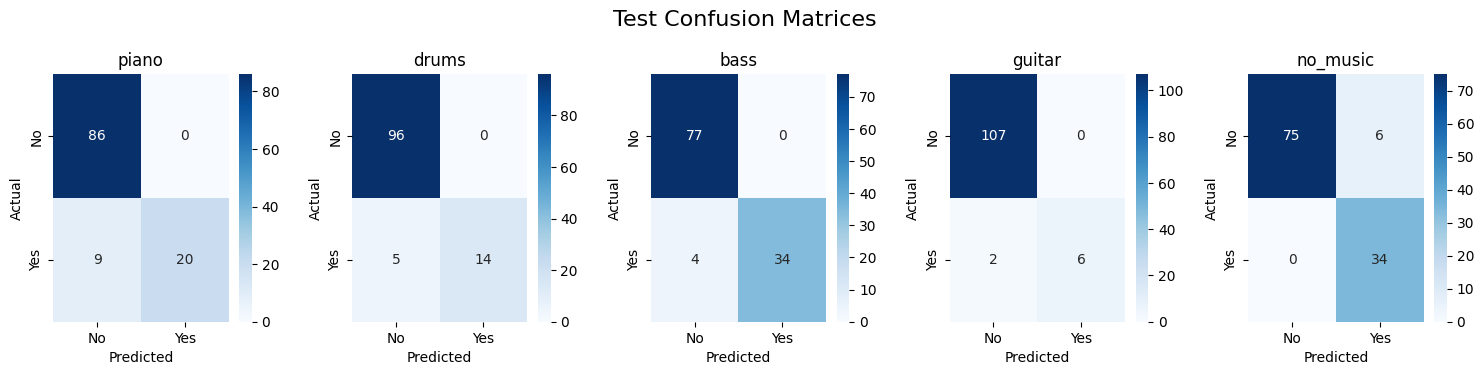

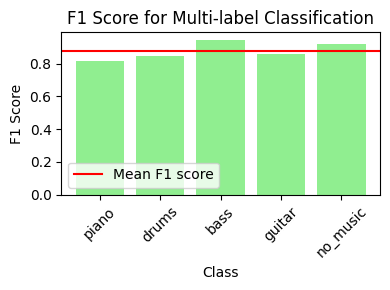

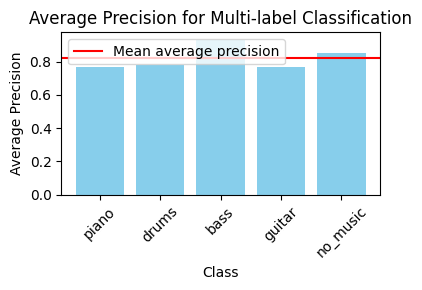


--- Fold End ---
--- Fold 4 ---
Epoch 1/5 | Train Loss: 21.8527 | Train Accuracy: 79.62%
Validation Accuracy: 4.35%


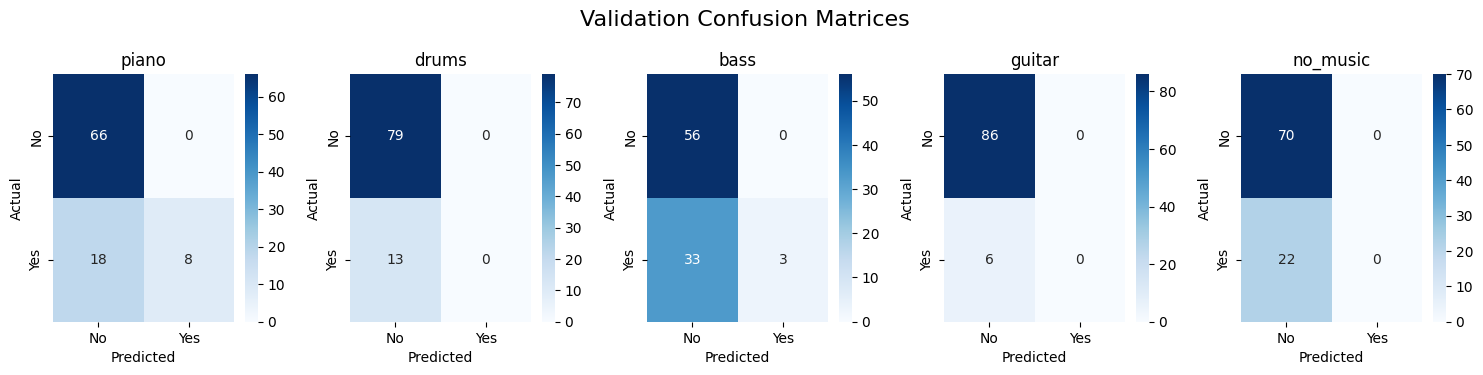

Epoch 2/5 | Train Loss: 13.5145 | Train Accuracy: 89.57%
Validation Accuracy: 69.57%
Epoch 3/5 | Train Loss: 9.9458 | Train Accuracy: 91.96%
Validation Accuracy: 69.57%
Epoch 4/5 | Train Loss: 7.4679 | Train Accuracy: 94.40%
Validation Accuracy: 81.52%
Epoch 5/5 | Train Loss: 6.8418 | Train Accuracy: 94.73%
Validation Accuracy: 88.04%

--- Final Test Evaluation ---
Test Accuracy: 85.22%


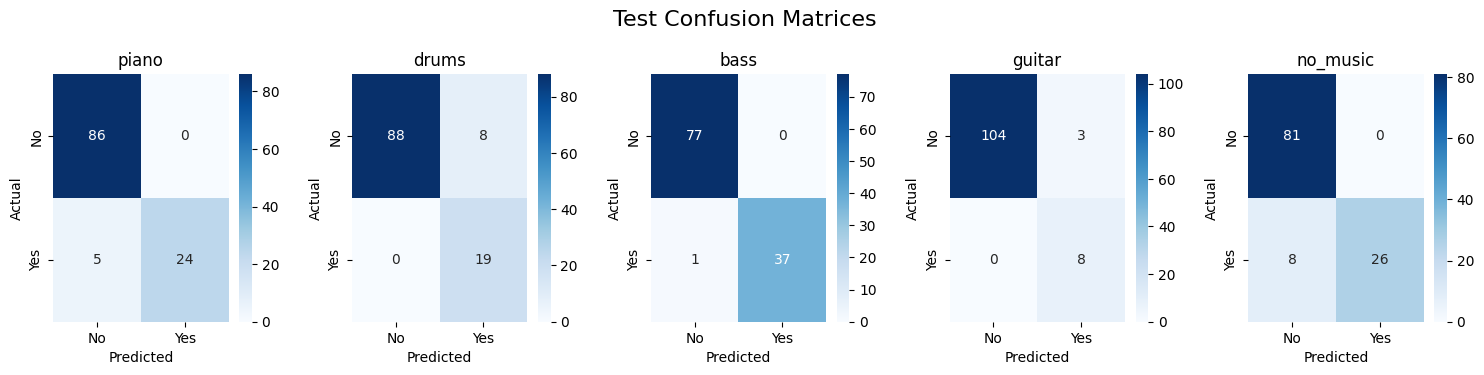

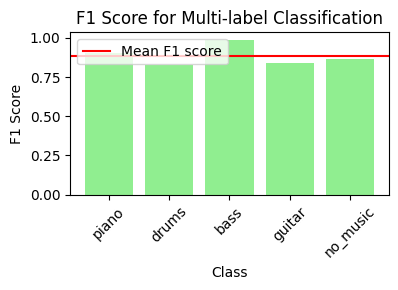

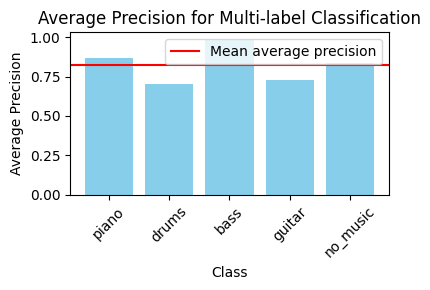


--- Fold End ---
--- Fold 5 ---
Epoch 1/5 | Train Loss: 23.8207 | Train Accuracy: 77.23%
Validation Accuracy: 30.43%


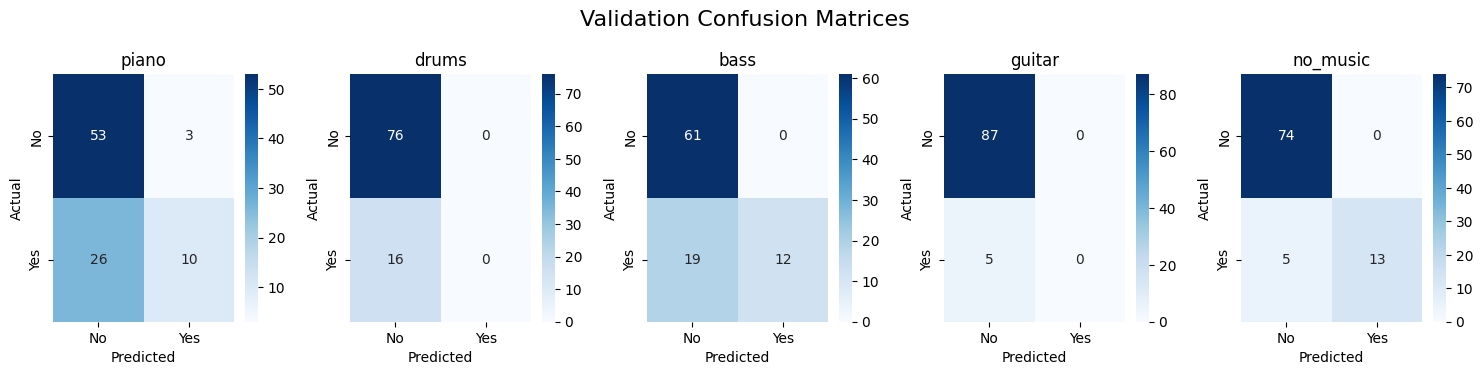

Epoch 2/5 | Train Loss: 14.9597 | Train Accuracy: 88.64%
Validation Accuracy: 56.52%
Epoch 3/5 | Train Loss: 11.2093 | Train Accuracy: 91.30%
Validation Accuracy: 66.30%
Epoch 4/5 | Train Loss: 8.6924 | Train Accuracy: 92.66%
Validation Accuracy: 81.52%
Epoch 5/5 | Train Loss: 7.8844 | Train Accuracy: 94.24%
Validation Accuracy: 70.65%

--- Final Test Evaluation ---
Test Accuracy: 77.39%


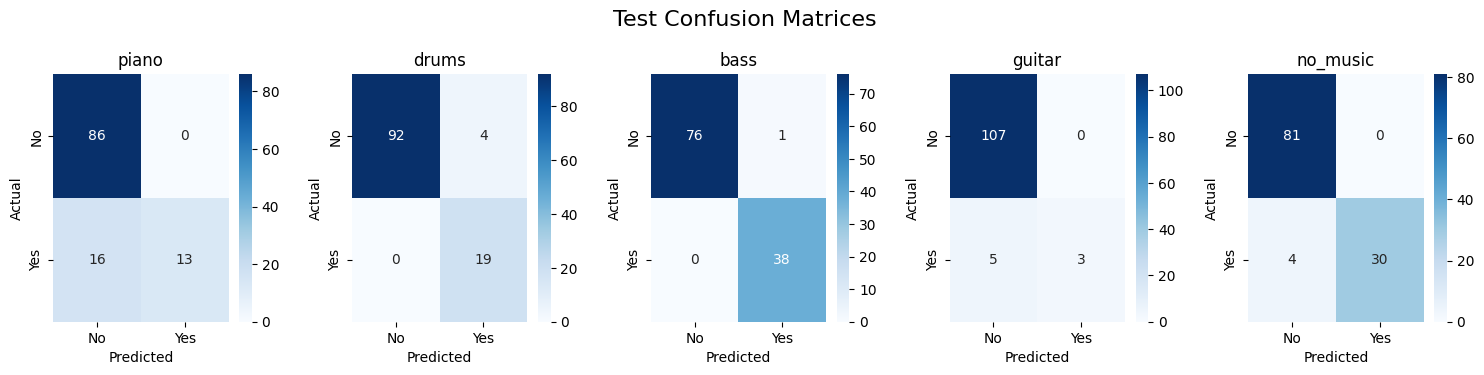

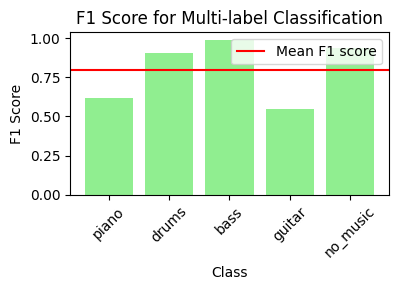

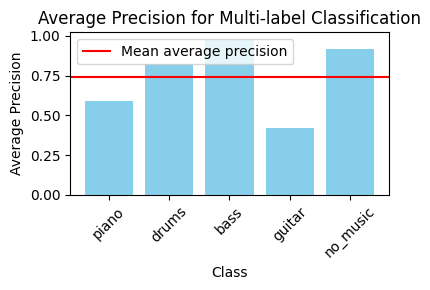


--- Fold End ---


In [10]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, random_split, Subset

full_dataset = BabySlakhDataset(stem_dict)

total_len = len(full_dataset)
test_len = int(0.2 * total_len)
train_val_len = total_len - test_len

train_val_dataset, test_dataset = random_split(full_dataset, [train_val_len, test_len])

# Cross-validation setup for the train+val dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the results for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(range(train_val_len))):
    print(f"--- Fold {fold+1} ---")
    
    # Create subsets for the current fold
    train_subset = Subset(train_val_dataset, train_idx)
    val_subset = Subset(train_val_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

    # Model initialization (reset the model for each fold)
    model = InstrumentClassifier(num_classes=len(LABELS))

    # Train the model with validation tracking
    train_with_val(model, train_loader, val_loader, epochs=5)

    # Evaluate on the test set after training on each fold
    print("\n--- Final Test Evaluation ---")
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    evaluate(model, test_loader, label="Test")

    print("\n--- Fold End ---")

Testing

c:\Users\Daphne\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Test Accuracy: 82.50%


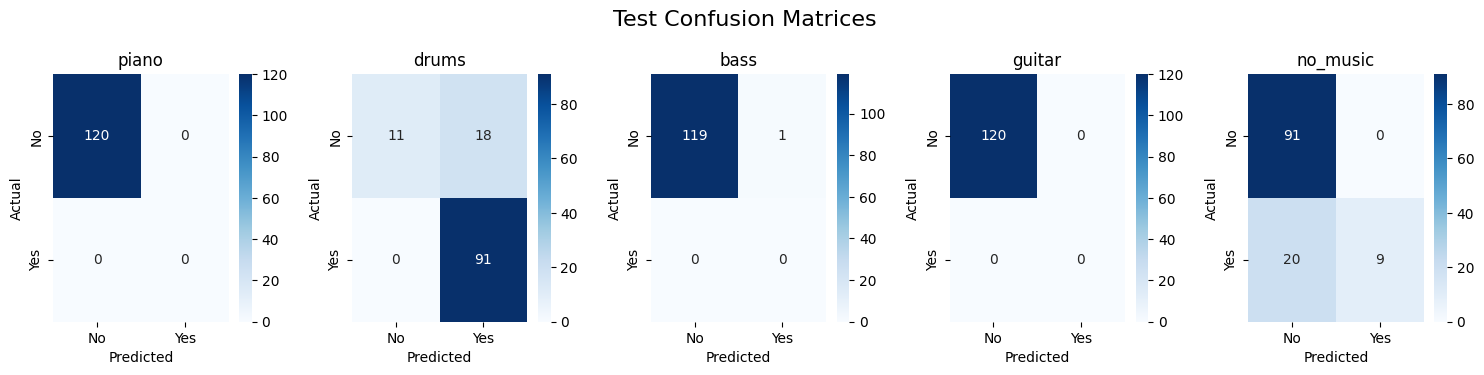

c:\Users\Daphne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\Daphne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


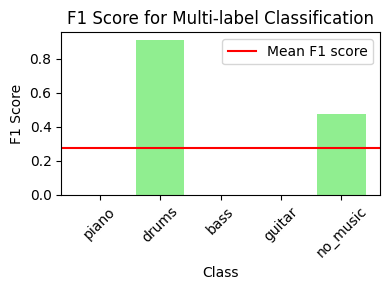

c:\Users\Daphne\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\Daphne\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\Daphne\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


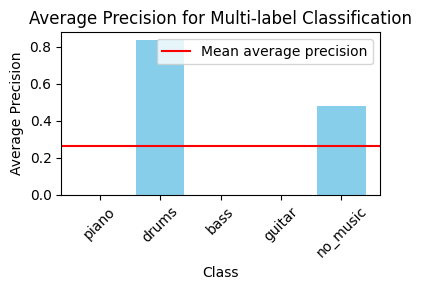

[[False False False False  True]
 [False False False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False False False False  True]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  True False False False]
 [False  T

In [11]:
test_dict = {
    drums_path: [LABELS["drums"]],
}

test = BabySlakhDataset(test_dict)
test_load = DataLoader(test, batch_size=8, shuffle=False)


accuracy, predictions = evaluate(model, test_load, label="Test")
print(predictions)

In [ ]:
class_counts = np.sum(predictions, axis=0)
    
# Classify a label as True if it appears more than the threshold
song_label = (class_counts > 10).astype(int)
LABELS = {
    "piano": 0,
    "drums": 1,
    "bass": 2,
    "guitar": 3,
    "no_music": 4
}

labels = []
for label, num in LABELS.items():
  if song_label[num] == 1:
    labels.append(label)


print(labels)


['drums']
